## Car Price Analysis

First of all, we have to import libraries we are going to use

In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')

To make Car Price Prediction model we need to use Regression model. And a Regression model needs the data. That's why, firstly, we have to scrap our data. I will do it from turbo.az 

In [3]:
def get_car_info(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    info = soup.find('div', class_='product-properties-container')
    info_rows = info.find_all('li')
    
    car_info={}
    for index, row in enumerate(info_rows):
        try:
            content_key = row.find('label').get_text()
            content_value = row.find('div', class_ ='product-properties-value' ).get_text()
            car_info[content_key] = content_value
        except:
            continue
    return car_info
    

This function get the url adress of the car and get all important information about the car that had been set

In the code below we get link adress of cars from page 1 to 20

In [4]:
base_path = 'https://turbo.az/'
car_info_list = []
lst = []
link_list = []

In [5]:
for j in range(1,20):
    url = 'https://turbo.az/autos?page={}'.format(j)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    cars = soup.select('.products a')
    for i in cars:
        lst.append(i['href'])


for i in lst:
    if i.startswith('/autos')==True and i.endswith('bookmarks')==False:
        link_list.append(base_path+i)
    

After getting link adresses of cars now we can use our function to scrap the data

In [6]:
for i in link_list:
    try:
        car_info_list.append(get_car_info(i))
    except:
        continue

In [3]:
import json

def save_data(title,data):
    with open(title, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
        
        
def load_data(title):
    with open(title, encoding='utf-8') as f:
        return json.load(f)

"save_data" function helps us to save our data in a json file and "load_data" helps us to load data into jupyter notebook

In [9]:
save_data('cars.json', car_info_list)

In [5]:
cars = load_data('cars.json')

In [6]:
car_data = pd.DataFrame(cars)

In [7]:
car_data.head()

,Şəhər,Marka,Model,Buraxılış ili,Ban növü,Rəng,Mühərrik,Mühərrikin gücü,Yanacaq növü,Yürüş,Sürətlər qutusu,Ötürücü,Yeni,Qiymət
0,Sumqayıt,Hyundai,Sonata,2019,Sedan,Boz,1.6 L,200 a.g.,Benzin,16 000 km,Avtomat,Ön,Xeyr,30 500 $
1,Bakı,Volkswagen,Taos,2021,Offroader / SUV,Bej,1.4 L,150 a.g.,Benzin,0 km,Avtomat,Ön,Bəli,52 900 AZN
2,Bakı,Toyota,Land Cruiser,2021,Offroader / SUV,Qara,3.5 L,415 a.g.,Benzin,0 km,Avtomat,Tam,Bəli,119 600 $
3,Bakı,Ford,Fusion,2016,Sedan,Tünd qırmızı,1.5 L,151 a.g.,Benzin,34 500 km,Avtomat,Ön,Xeyr,22 800 AZN
4,Bakı,Opel,Astra,2008,Hetçbek / Liftbek,Gümüşü,1.3 L,90 a.g.,Dizel,175 110 km,Mexaniki,Ön,Xeyr,11 900 AZN


### Exploratory data analysis

1. Identify the trends in the sales of cars and car industry in Azerbaijan in general.

2. Correlation between price and condition, which is then further extended by year, current location of car, number of cylinders in the vehicle and vehicle mileage.

In [8]:
car_data.dtypes

Şəhər              object
Marka              object
Model              object
Buraxılış ili      object
Ban növü           object
Rəng               object
Mühərrik           object
Mühərrikin gücü    object
Yanacaq növü       object
Yürüş              object
Sürətlər qutusu    object
Ötürücü            object
Yeni               object
Qiymət             object
dtype: object

#### Data Cleaning

We see that some columns don't have correct types. We have to do data cleaning.

In [9]:
car_data['Buraxılış ili'] = car_data['Buraxılış ili'].astype(int)

In our price column, some prices is showed in Azerbaijan manat and others in US dollars. We are going to convert all of them into AZN, and change its dtype to float.

In [10]:
car_data['Qiymət'] = car_data['Qiymət'].str.replace(' ','').astype(str)
x = car_data[car_data['Qiymət'].str.contains('AZN')==False]['Qiymət'].str[:-1].astype(int)*1.70
y = car_data[car_data['Qiymət'].str.contains('AZN')]['Qiymət'].str[:-3].astype(int)
car_data['Price'] = pd.concat([x,y])
car_data.drop('Qiymət', axis=1, inplace=True)

If we substract produced date of the car from today's date, we can find car's age 

In [11]:
car_data['Age'] = pd.datetime.today().year - car_data['Buraxılış ili']

In [12]:
car_data['Mühərrikin gücü'] = car_data['Mühərrikin gücü'].str.replace('a.g.','').str.strip().astype(int)

In [13]:
car_data['Mühərrik'] = car_data['Mühərrik'].str.replace('L','').str.strip().astype(float)

In [14]:
car_data['Yürüş'] = car_data['Yürüş'].str.replace('km','').str.replace(' ','').astype(int)

In [15]:
car_data.head()

,Şəhər,Marka,Model,Buraxılış ili,Ban növü,Rəng,Mühərrik,Mühərrikin gücü,Yanacaq növü,Yürüş,Sürətlər qutusu,Ötürücü,Yeni,Price,Age
0,Sumqayıt,Hyundai,Sonata,2019,Sedan,Boz,1.6,200,Benzin,16000,Avtomat,Ön,Xeyr,51850.0,2
1,Bakı,Volkswagen,Taos,2021,Offroader / SUV,Bej,1.4,150,Benzin,0,Avtomat,Ön,Bəli,52900.0,0
2,Bakı,Toyota,Land Cruiser,2021,Offroader / SUV,Qara,3.5,415,Benzin,0,Avtomat,Tam,Bəli,203320.0,0
3,Bakı,Ford,Fusion,2016,Sedan,Tünd qırmızı,1.5,151,Benzin,34500,Avtomat,Ön,Xeyr,22800.0,5
4,Bakı,Opel,Astra,2008,Hetçbek / Liftbek,Gümüşü,1.3,90,Dizel,175110,Mexaniki,Ön,Xeyr,11900.0,13


#### Sale trends in different regions of Azerbaijan:

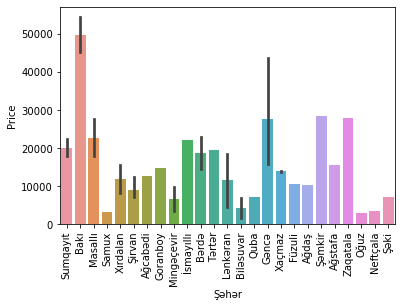

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
 
sns.barplot(x = 'Şəhər',
            y = 'Price',
            data = car_data)

plt.xticks(rotation=90)
plt.show()

In [17]:
count_df = car_data.groupby('Şəhər').count()[['Marka']]
count_df

,Marka
Şəhər,
Ağcabədi,1
Ağdaş,1
Ağstafa,1
Bakı,560
Biləsuvar,2
Bərdə,2
Füzuli,1
Goranboy,1
Gəncə,8


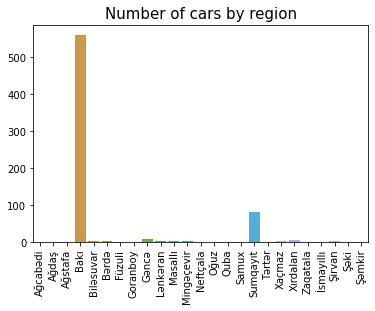

In [18]:
values = list(count_df['Marka'])
labels = list(count_df.index)
plt.title(label='Number of cars by region', fontsize=15)
sns.barplot(labels,values)
plt.xticks(rotation=90)
plt.show()

In [19]:
average_df = car_data.groupby('Şəhər').mean()[['Price']]
average_df

,Price
Şəhər,
Ağcabədi,12600.000000
Ağdaş,10300.000000
Ağstafa,15550.000000
Bakı,49755.169643
Biləsuvar,4200.000000
Bərdə,18650.000000
Füzuli,10500.000000
Goranboy,14700.000000
Gəncə,27583.750000


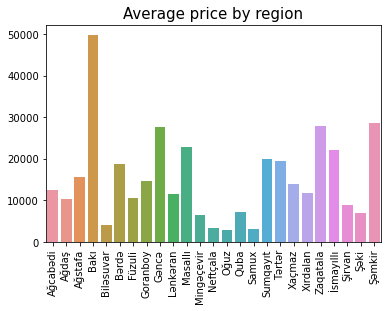

In [20]:
values = list(average_df['Price'])
labels = list(average_df.index)
plt.title(label='Average price by region', fontsize=15)
sns.barplot(labels,values)
plt.xticks(rotation=90)
plt.show()

#### Market Share of different car manufacturers:

In [21]:
marka_count_df = car_data.groupby('Marka').agg({'Model':'count'})
marka_count_df

,Model
Marka,
Audi,11
BMW,49
Baic,1
Benelli,1
Cadillac,1
Changan,1
Chevrolet,58
Chrysler,2
Daewoo,1


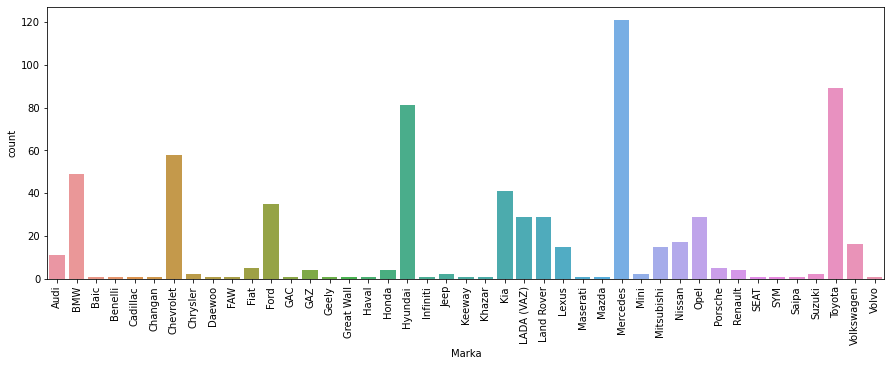

In [22]:
f, ax = plt.subplots(figsize=(15,5)) 
sns.barplot(x = marka_count_df.index,
            y = 'Model',
            data = marka_count_df)

plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

In [23]:
marka_mean_df = car_data.groupby('Marka').mean()[['Price']]
marka_mean_df

,Price
Marka,
Audi,54512.727273
BMW,73837.142857
Baic,28800.000000
Benelli,5500.000000
Cadillac,112200.000000
Changan,20500.000000
Chevrolet,20089.051724
Chrysler,9400.000000
Daewoo,6800.000000


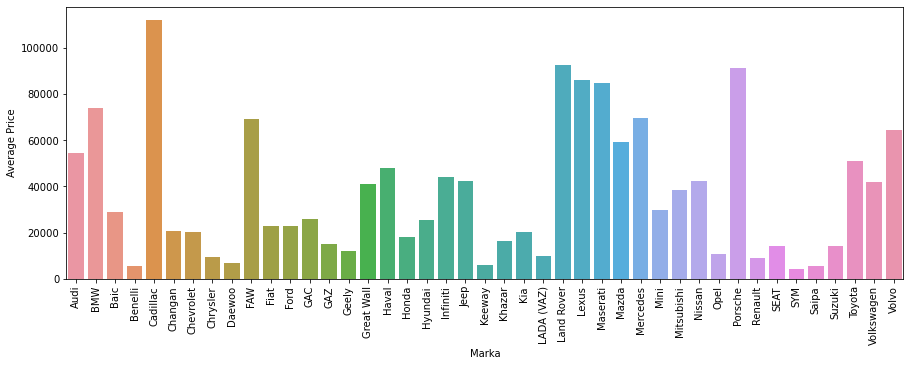

In [24]:
f, ax = plt.subplots(figsize=(15,5)) 
sns.barplot(x = marka_mean_df.index,
            y = 'Price',
            data = marka_mean_df)

plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

#### Types of vehicle and the Fuel they use :

In [25]:
fuel_df = car_data.groupby('Yanacaq növü').count()[['Marka']]
fuel_df

,Marka
Yanacaq növü,
Benzin,550
Dizel,110
Elektro,1
Hibrid,22
Qaz,1


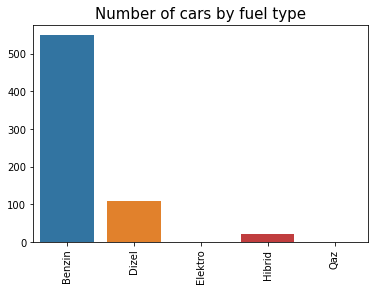

In [26]:
values = list(fuel_df['Marka'])
labels = list(fuel_df.index)
plt.title(label='Number of cars by fuel type', fontsize=15)
sns.barplot(labels,values)
plt.xticks(rotation=90)
plt.show()

#### Trend of number of cars for sale according to the year they were manufactured in :

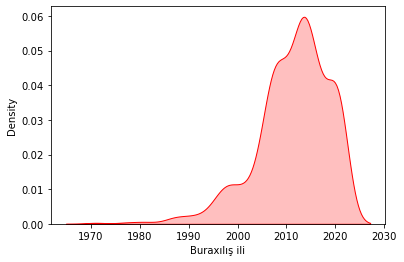

In [27]:
sns.kdeplot(data=car_data, x="Buraxılış ili", shade=True, color="r")
plt.show()

In [28]:
year_df = car_data.groupby('Buraxılış ili').count()[['Marka']]

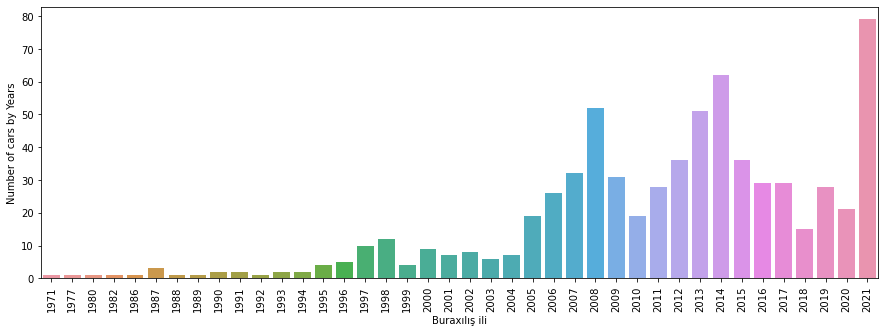

In [29]:
f, ax = plt.subplots(figsize=(15,5)) 
sns.barplot(x = year_df.index,
            y = 'Marka',
            data = year_df)
plt.ylabel('Number of cars by Years')
plt.xticks(rotation=90)
plt.show()

#### Relation of price other variables of a car:

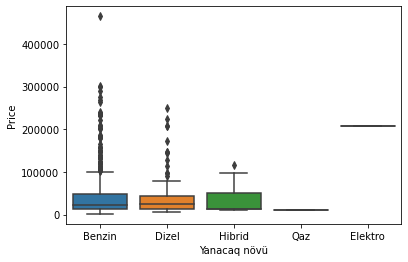

In [30]:
ax = sns.boxplot(x="Yanacaq növü", y="Price", data=car_data)

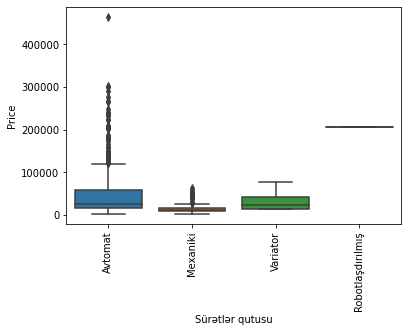

In [31]:
ax = sns.boxplot(x="Sürətlər qutusu", y="Price", data=car_data)
plt.xticks(rotation=90)
plt.show()

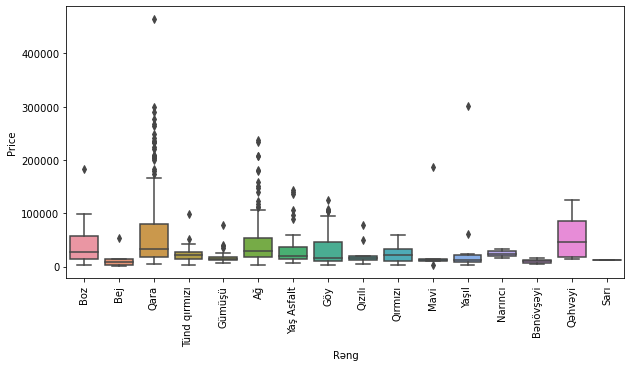

In [32]:
f, ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x="Rəng", y="Price", data=car_data)
plt.xticks(rotation=90)
plt.show()

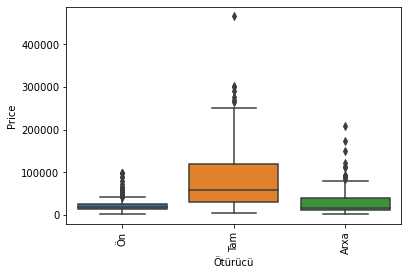

In [33]:
ax = sns.boxplot(x="Ötürücü", y="Price", data=car_data)
plt.xticks(rotation=90)
plt.show()

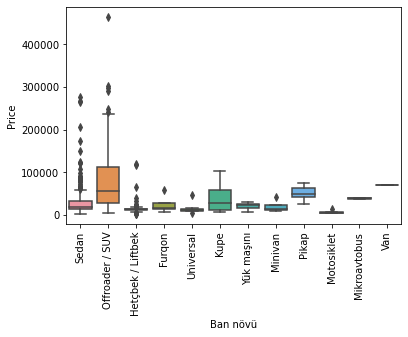

In [34]:
ax = sns.boxplot(x="Ban növü", y="Price", data=car_data)
plt.xticks(rotation=90)
plt.show()

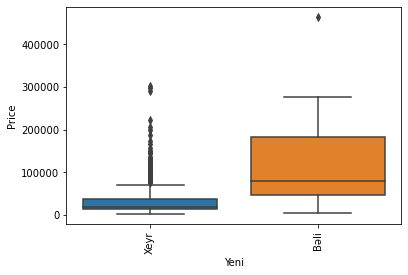

In [35]:
ax = sns.boxplot(x="Yeni", y="Price", data=car_data)
plt.xticks(rotation=90)
plt.show()